# Modelos para variable target binaria

## Imports y data load

In [1]:
# Standard library
import os
from datetime import datetime
from imblearn.pipeline import Pipeline
from pathlib import Path
import sys

# Data & Numerical
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import optuna
from scipy.stats import uniform, randint

# Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, 
    ConfusionMatrixDisplay, f1_score, make_scorer, 
    precision_score, recall_score, roc_auc_score)
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# Imbalanced-learn
from imblearn.over_sampling import SMOTE

# Gradient Boosting
import lightgbm as lgb
import xgboost as xgb

/Users/sofiaforni/Documents/FCEN UBA Maestria/aprendizaje automatico 2025/aprendizaje_automatico_desertores/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Add parent directory to path
parent_dir = Path().resolve().parent
sys.path.insert(0, str(parent_dir))

# Custom imports
from scripts.results_analyzer import ResultsAnalyzer

In [3]:
data_path = '../data/base_procesada_binaria.csv'

#Constants

TARGET = 'target_binaria'

In [4]:
df_int_binario = pd.read_csv(data_path)
df_int_binario.head()

,Estudios_máximos_antes_de_la_inscripción,estado_civil,sexo,desplazado,Asistencia_diurna/nocturna,Cualificación_promedio_de_estudios_previos,Puntaje_en_examen_de_ingreso,Necesidades_educativas_especiales,Tiene_deuda,Pago_de_matrícula_al_día,...,Carrera_Gestión,Carrera_Ingeniería Informática,Carrera_Periodismo y Comunicación,Carrera_Psicología,Carrera_Publicidad y Marketing,Carrera_Química,Carrera_Sociología,Carrera_Turismo,Carrera_Veterinaria,target_binaria
0,3,1,0,0,1,66,65,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,3,1,0,1,1,69,66,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3,1,0,1,1,69,63,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,4,1,0,1,1,68,68,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,3,1,1,1,1,68,70,0,0,1,...,0,0,1,0,0,0,0,0,0,1


In [5]:
# Separar features y target
X = df_int_binario.drop(TARGET, axis=1)
y = df_int_binario[TARGET]

# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

## Models

### Regresión logística

In [6]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=10000))
])


param_grid = {
    'classifier__solver': ['liblinear', 'lbfgs', 'saga'],
    'classifier__C': [0.01, 0.1, 1, 10, 100],  
    'classifier__penalty': ['l2'],  # l1 solo con liblinear/saga
    'classifier__class_weight': [None, 'balanced'] 
}

# Create GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,  
    scoring='f1',
    n_jobs=-1,  
    verbose=1
)

grid_search.fit(X_train, y_train)


for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")

print(f"\nMejor F1-score en validación cruzada: {grid_search.best_score_:.4f}")


best_pipeline = grid_search.best_estimator_

y_pred = best_pipeline.predict(X_test)
y_pred_proba = best_pipeline.predict_proba(X_test)


accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
classifier__C: 1
classifier__class_weight: None
classifier__penalty: l2
classifier__solver: saga

Mejor F1-score en validación cruzada: 0.8895



RESULTADOS EN TEST SET - LOGISTIC REGRESSION
Accuracy:  0.8574
Precision: 0.8633
Recall:    0.9151
F1-Score:  0.8885
ROC-AUC:   0.9200

------------------------------------------------------------
REPORTE DE CLASIFICACIÓN:
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.76      0.80      4365
           1       0.86      0.92      0.89      7137

    accuracy                           0.86     11502
   macro avg       0.85      0.84      0.85     11502
weighted avg       0.86      0.86      0.86     11502



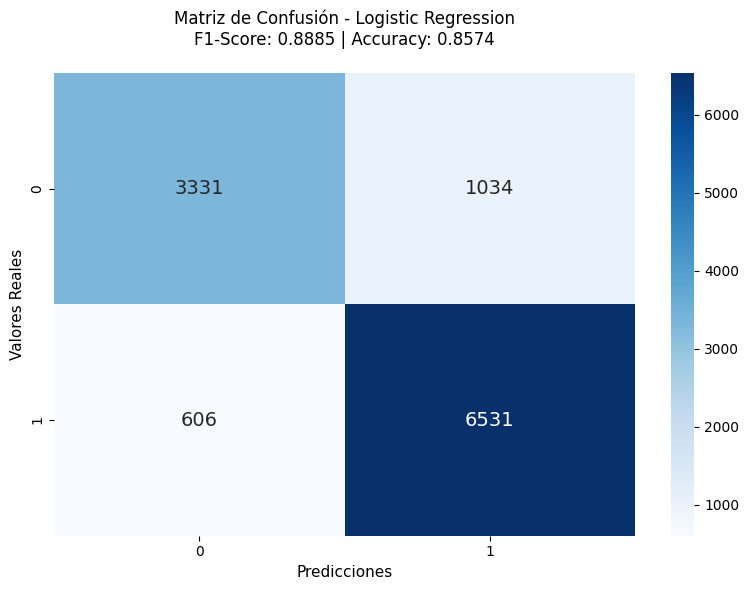

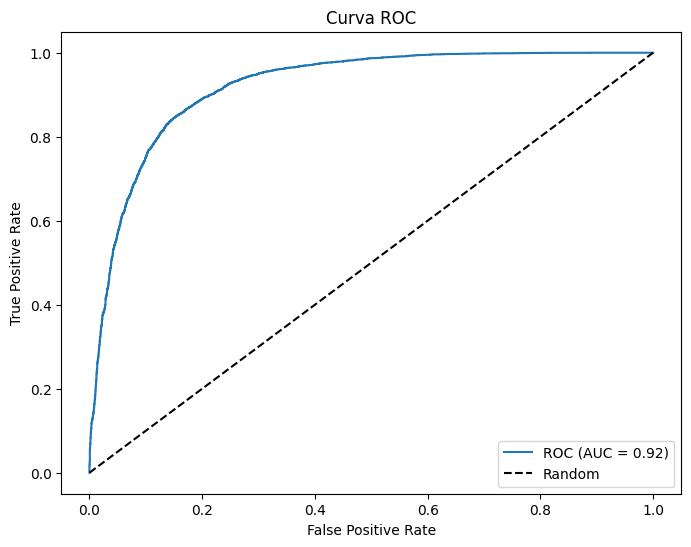

In [7]:
analyzer = ResultsAnalyzer()
results_df = analyzer.evaluar_y_guardar_modelo(grid_search, X_test, y_test, y_pred, y_pred_proba,
                          nombre_modelo="Logistic Regression")


In [8]:
results_df.head()

,Modelo,Hiperparametros,Accuracy,F1_Score,Precision,Recall,ROC_AUC,CV_F1_Mean,CV_F1_Std,Fecha
0,Logistic Regression,"{'classifier__C': 1, 'classifier__class_weight...",0.8574,0.8885,0.8633,0.9151,0.92,0.8895,0.0022,2025-10-17 17:51:41


Pipeline detectado. Usando: LogisticRegression
Modelo multiclase: 2 clases
Clases: [0 1]


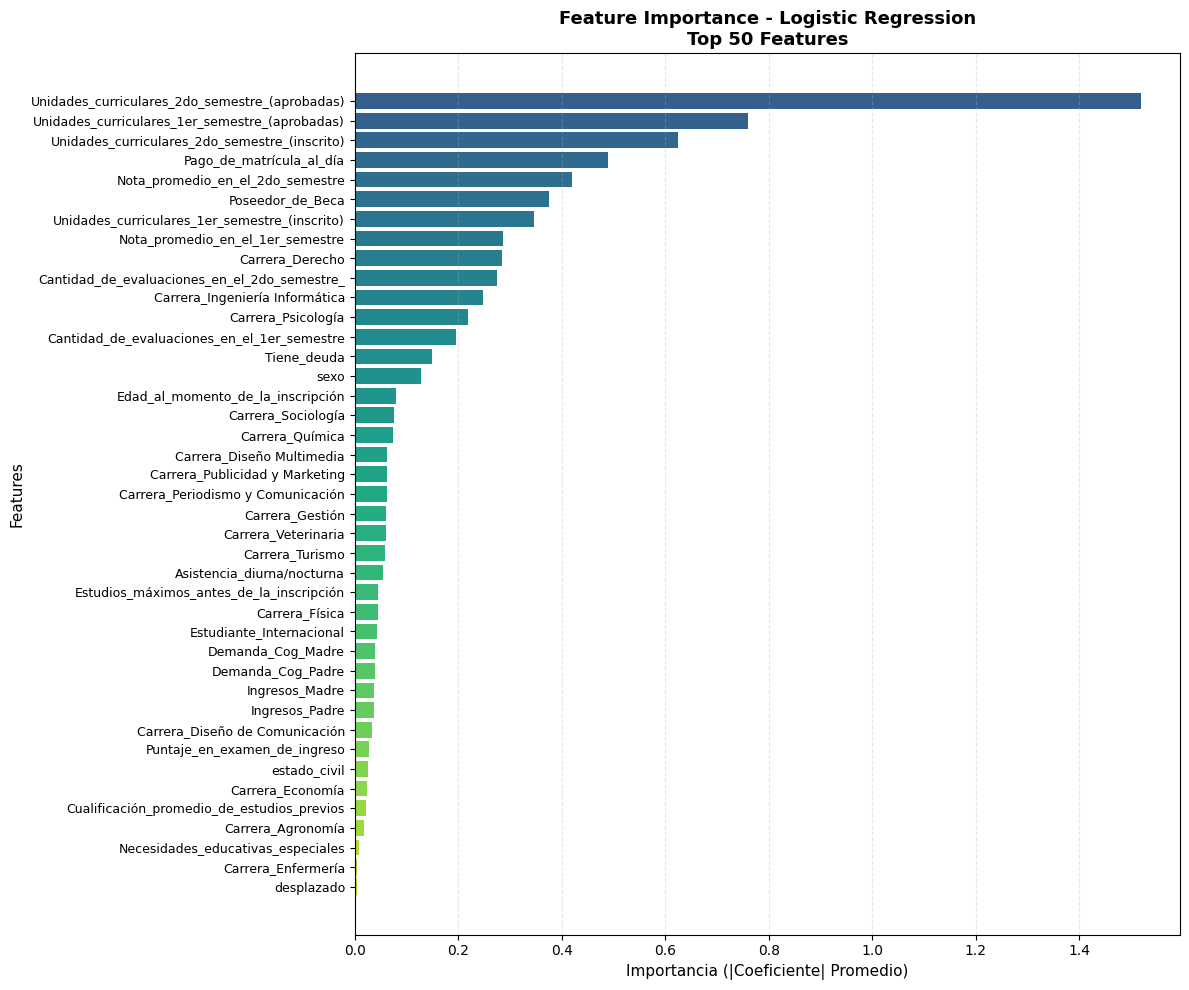


Top 41 Features:
                                       feature  importance
Unidades_curriculares_2do_semestre_(aprobadas)    1.518340
Unidades_curriculares_1er_semestre_(aprobadas)    0.759649
 Unidades_curriculares_2do_semestre_(inscrito)    0.624119
                      Pago_de_matrícula_al_día    0.488529
              Nota_promedio_en_el_2do_semestre    0.419529
                              Poseedor_de_Beca    0.375895
 Unidades_curriculares_1er_semestre_(inscrito)    0.345347
              Nota_promedio_en_el_1er_semestre    0.286576
                               Carrera_Derecho    0.283575
  Cantidad_de_evaluaciones_en_el_2do_semestre_    0.274568
                Carrera_Ingeniería Informática    0.247043
                            Carrera_Psicología    0.219000
   Cantidad_de_evaluaciones_en_el_1er_semestre    0.195908
                                   Tiene_deuda    0.149563
                                          sexo    0.127781
             Edad_al_momento_de_la_ins

In [9]:
feature_importance_df = analyzer.plot_feature_importance(
    modelo=best_pipeline,
    X_train=X_train,
    top_n=50,
    figsize=(12, 10)
)

### Logistic Regression con SMOTE

In [10]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=10000))
])


param_grid = {
    'classifier__solver': ['liblinear', 'lbfgs', 'saga'],
    'classifier__C': [0.01, 0.1, 1, 10, 50],
    'classifier__penalty': ['l2'],
    'classifier__class_weight': [None, 'balanced'] 
}

#GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,  
    scoring='f1',
    n_jobs=-1,  
    verbose=1
)

grid_search.fit(X_train_smote, y_train_smote)


print("\nMejores parámetros:")
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")

print(f"\nMejor F1-score en validación cruzada: {grid_search.best_score_:.4f}")


best_pipeline = grid_search.best_estimator_

y_pred = best_pipeline.predict(X_test)
y_pred_proba = best_pipeline.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

Fitting 5 folds for each of 30 candidates, totalling 150 fits

Mejores parámetros:
classifier__C: 0.1
classifier__class_weight: None
classifier__penalty: l2
classifier__solver: saga

Mejor F1-score en validación cruzada: 0.8763



RESULTADOS EN TEST SET - LOGISTIC REGRESSION CON SMOTE
Accuracy:  0.8570
Precision: 0.8697
Recall:    0.9051
F1-Score:  0.8871
ROC-AUC:   0.9189

------------------------------------------------------------
REPORTE DE CLASIFICACIÓN:
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.78      0.81      4365
           1       0.87      0.91      0.89      7137

    accuracy                           0.86     11502
   macro avg       0.85      0.84      0.85     11502
weighted avg       0.86      0.86      0.86     11502



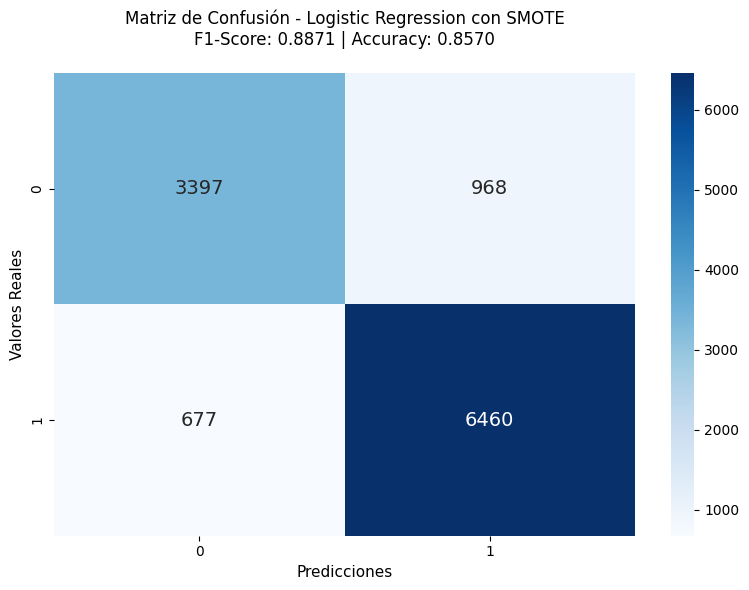

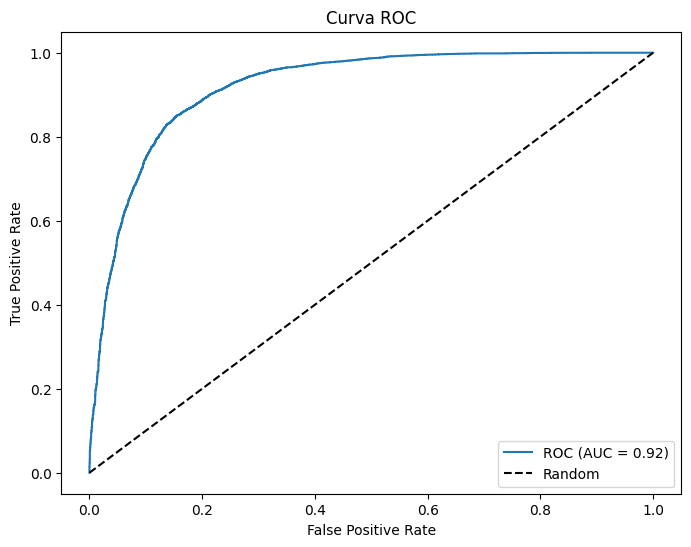

In [11]:
results = analyzer.evaluar_y_guardar_modelo(grid_search, X_test, y_test, y_pred, y_pred_proba,
                          nombre_modelo="Logistic Regression con SMOTE")

In [12]:
results_df = pd.concat([results_df, results], ignore_index=True)

Pipeline detectado. Usando: LogisticRegression
Modelo multiclase: 2 clases
Clases: [0 1]


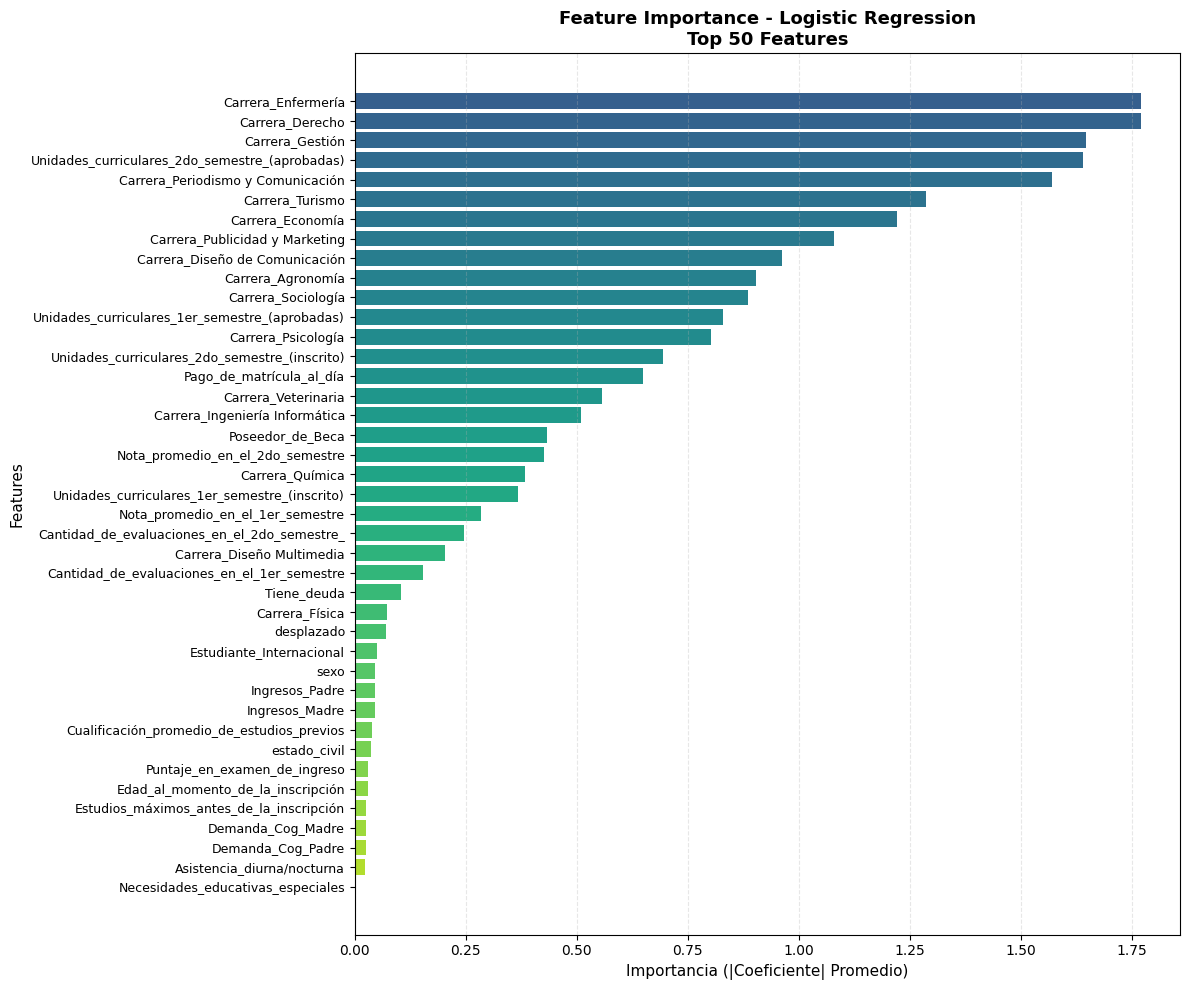


Top 41 Features:
                                       feature  importance
                            Carrera_Enfermería    1.770299
                               Carrera_Derecho    1.770166
                               Carrera_Gestión    1.647098
Unidades_curriculares_2do_semestre_(aprobadas)    1.640889
             Carrera_Periodismo y Comunicación    1.571616
                               Carrera_Turismo    1.287770
                              Carrera_Economía    1.222384
                Carrera_Publicidad y Marketing    1.079125
                Carrera_Diseño de Comunicación    0.962693
                             Carrera_Agronomía    0.904771
                            Carrera_Sociología    0.885793
Unidades_curriculares_1er_semestre_(aprobadas)    0.829558
                            Carrera_Psicología    0.802485
 Unidades_curriculares_2do_semestre_(inscrito)    0.694218
                      Pago_de_matrícula_al_día    0.648945
                           Carrera_Vet

In [13]:
feature_importance_df = analyzer.plot_feature_importance(
    modelo=best_pipeline,
    X_train=X_train,
    top_n=50,
    figsize=(12, 10))

### Máquina de vectores de soporte (SVM) 

In [14]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(random_state=42, probability=True))
])

param_grid = {
    'classifier__C': [0.1, 1, 5], 
    'classifier__kernel': ['linear'],  
    'classifier__gamma': ['scale', 'auto'],
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

y_pred_svm = best_model.predict(X_test)
y_pred_proba_svm = best_model.predict_proba(X_test)

Fitting 3 folds for each of 6 candidates, totalling 18 fits



RESULTADOS EN TEST SET - SVM
Accuracy:  0.8584
Precision: 0.8622
Recall:    0.9186
F1-Score:  0.8895
ROC-AUC:   0.9192

------------------------------------------------------------
REPORTE DE CLASIFICACIÓN:
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.76      0.80      4365
           1       0.86      0.92      0.89      7137

    accuracy                           0.86     11502
   macro avg       0.86      0.84      0.85     11502
weighted avg       0.86      0.86      0.86     11502



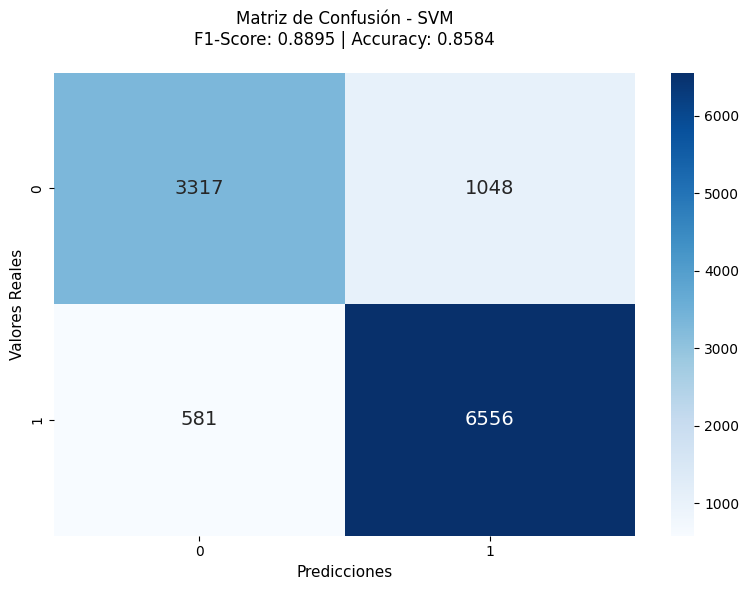

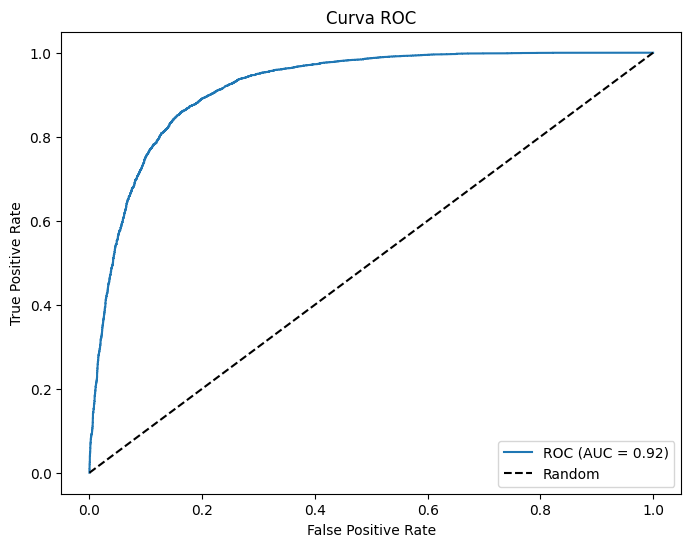

In [15]:
results = analyzer.evaluar_y_guardar_modelo(grid_search, X_test, y_test, y_pred = y_pred_svm, y_pred_proba = y_pred_proba_svm,
                          nombre_modelo="SVM")

In [16]:
results_df = pd.concat([results_df, results], ignore_index=True)
results_df.to_csv('../results/resultados_modelos_binaria.csv', index=False)

Pipeline detectado. Usando: SVC
Modelo multiclase: 2 clases
Clases: [0 1]


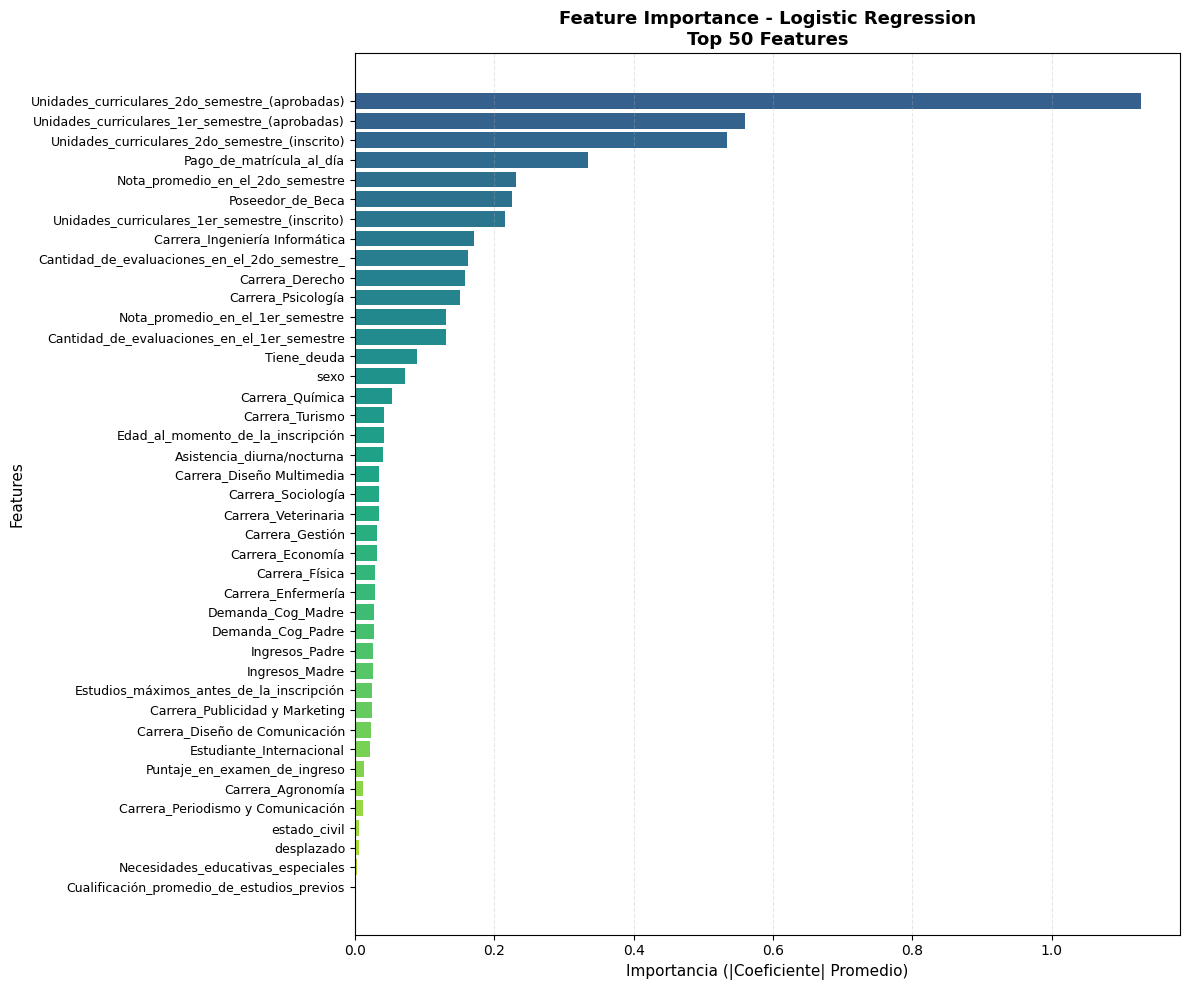


Top 41 Features:
                                       feature  importance
Unidades_curriculares_2do_semestre_(aprobadas)    1.127388
Unidades_curriculares_1er_semestre_(aprobadas)    0.559855
 Unidades_curriculares_2do_semestre_(inscrito)    0.534245
                      Pago_de_matrícula_al_día    0.334381
              Nota_promedio_en_el_2do_semestre    0.230994
                              Poseedor_de_Beca    0.225074
 Unidades_curriculares_1er_semestre_(inscrito)    0.216108
                Carrera_Ingeniería Informática    0.171093
  Cantidad_de_evaluaciones_en_el_2do_semestre_    0.162621
                               Carrera_Derecho    0.158345
                            Carrera_Psicología    0.151620
              Nota_promedio_en_el_1er_semestre    0.131526
   Cantidad_de_evaluaciones_en_el_1er_semestre    0.131341
                                   Tiene_deuda    0.089925
                                          sexo    0.071901
                               Carrera

In [17]:
feature_importance_df = analyzer.plot_feature_importance(
    modelo=best_model,
    X_train=X_train,
    top_n=50,
    figsize=(12, 10))

## KNN

In [18]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier())
])

param_grid = {
    'classifier__n_neighbors': range(3, 21),
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,  
    scoring='f1',
    n_jobs=-1,  
    verbose=1
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

Fitting 5 folds for each of 72 candidates, totalling 360 fits



RESULTADOS EN TEST SET - KNN
Accuracy:  0.8462
Precision: 0.8461
Recall:    0.9193
F1-Score:  0.8812
ROC-AUC:   0.9042

------------------------------------------------------------
REPORTE DE CLASIFICACIÓN:
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.73      0.78      4365
           1       0.85      0.92      0.88      7137

    accuracy                           0.85     11502
   macro avg       0.85      0.82      0.83     11502
weighted avg       0.85      0.85      0.84     11502



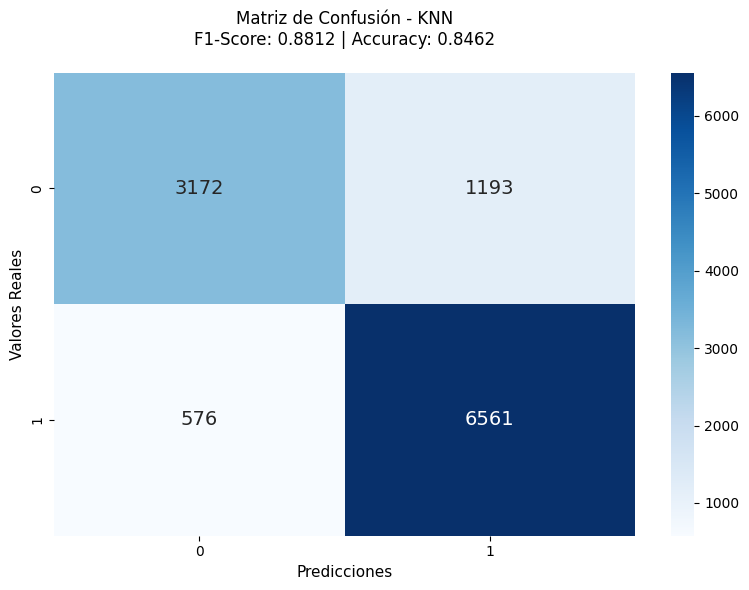

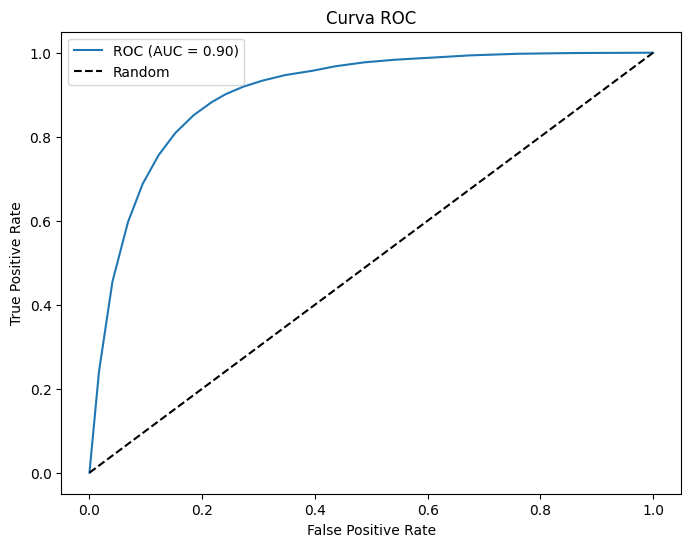

In [19]:
results = analyzer.evaluar_y_guardar_modelo(grid_search, X_test, y_test, y_pred, y_pred_proba,
                          nombre_modelo="KNN")

In [20]:
results_df = pd.concat([results_df, results], ignore_index=True)
results_df.to_csv('../results/resultados_modelos_binaria.csv', index=False)

### Árboles de Decisión 


In [21]:
# Pipeline para Random Forest
pipeline_rf = Pipeline([
    ('classifier', RandomForestClassifier(random_state=42))
])

# Parámetros para GridSearch
param_grid_rf = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__class_weight': ['balanced', None]
}

grid_search_rf = GridSearchCV(
    pipeline_rf,
    param_grid_rf,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search_rf.fit(X_train, y_train)


# Usar mejor modelo
best_model = grid_search_rf.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits



RESULTADOS EN TEST SET - RANDOM FOREST
Accuracy:  0.8614
Precision: 0.8669
Recall:    0.9175
F1-Score:  0.8915
ROC-AUC:   0.9233

------------------------------------------------------------
REPORTE DE CLASIFICACIÓN:
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.77      0.81      4365
           1       0.87      0.92      0.89      7137

    accuracy                           0.86     11502
   macro avg       0.86      0.84      0.85     11502
weighted avg       0.86      0.86      0.86     11502



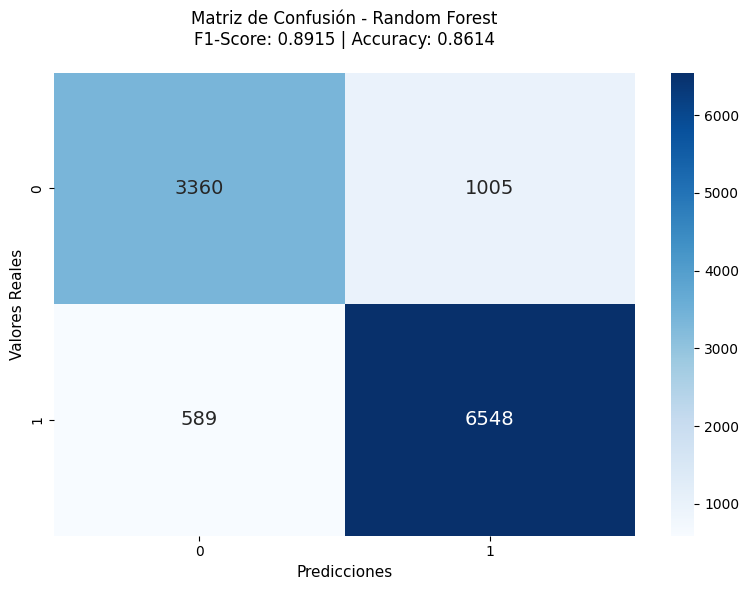

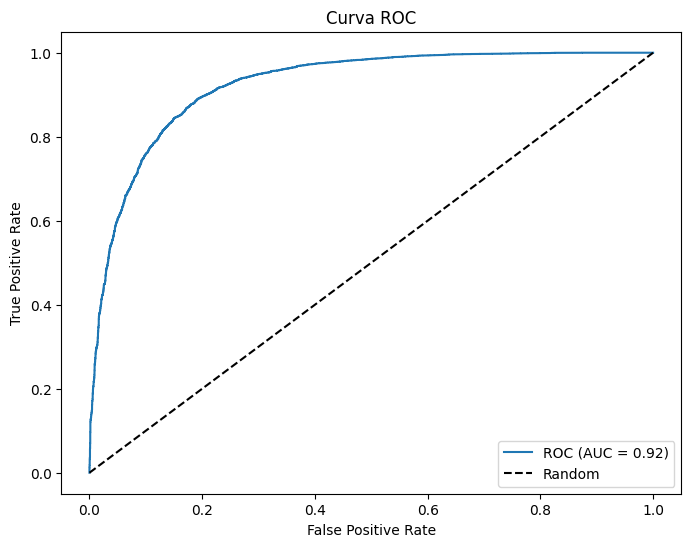

In [22]:
results = analyzer.evaluar_y_guardar_modelo(grid_search_rf, X_test, y_test, y_pred, y_pred_proba,
                          nombre_modelo="Random Forest")

In [23]:
results_df = pd.concat([results_df, results], ignore_index=True)
results_df.to_csv('../results/resultados_modelos_binaria.csv', index=False)

Pipeline detectado. Usando: RandomForestClassifier


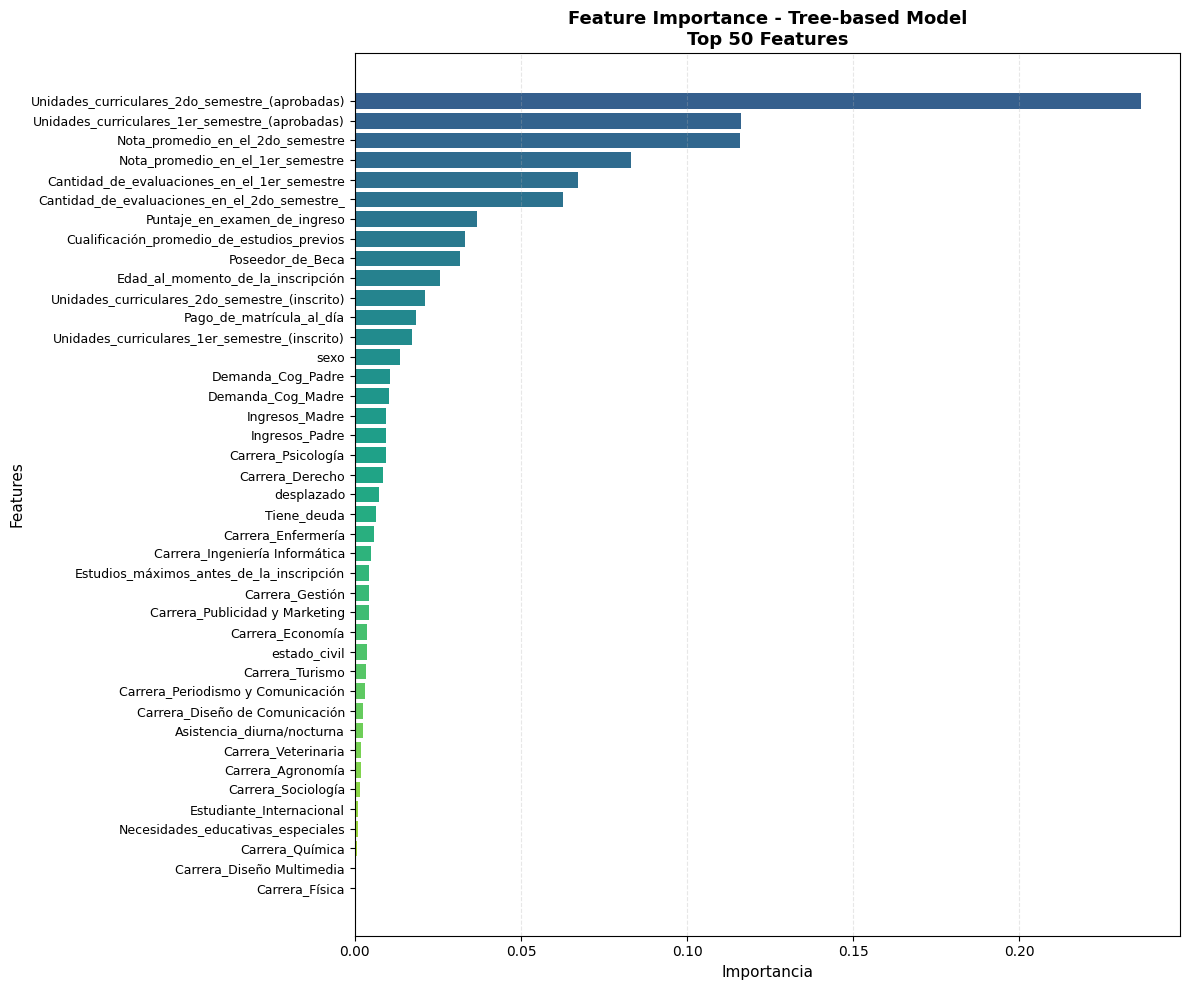


Top 41 Features:
                                       feature  importance
Unidades_curriculares_2do_semestre_(aprobadas)    0.236472
Unidades_curriculares_1er_semestre_(aprobadas)    0.116303
              Nota_promedio_en_el_2do_semestre    0.115833
              Nota_promedio_en_el_1er_semestre    0.083211
   Cantidad_de_evaluaciones_en_el_1er_semestre    0.067309
  Cantidad_de_evaluaciones_en_el_2do_semestre_    0.062547
                  Puntaje_en_examen_de_ingreso    0.036642
    Cualificación_promedio_de_estudios_previos    0.033174
                              Poseedor_de_Beca    0.031552
             Edad_al_momento_de_la_inscripción    0.025762
 Unidades_curriculares_2do_semestre_(inscrito)    0.021104
                      Pago_de_matrícula_al_día    0.018352
 Unidades_curriculares_1er_semestre_(inscrito)    0.017176
                                          sexo    0.013474
                             Demanda_Cog_Padre    0.010524
                             Demanda_C

In [24]:
feature_importance_df = analyzer.plot_feature_importance(
    modelo=best_model,
    X_train=X_train,
    top_n=50,
    figsize=(12, 10))

## Boosting

In [25]:
pipeline = Pipeline([
    ('classifier', lgb.LGBMClassifier(
        objective='binary',
        random_state=42,
        verbose=-1,
        n_jobs=1
    ))
])


param_grid = {
    'classifier__n_estimators': randint(100, 800),
    'classifier__max_depth': randint(3, 12),
    'classifier__learning_rate': uniform(0.01, 0.2),
    'classifier__num_leaves': randint(20, 150),
    'classifier__min_child_samples': randint(10, 100),
    'classifier__subsample': uniform(0.6, 0.4),
    'classifier__colsample_bytree': uniform(0.6, 0.4),
    'classifier__reg_alpha': uniform(0, 1),
    'classifier__reg_lambda': uniform(0, 1)
}

grid_search = RandomizedSearchCV(
    pipeline,
    param_grid,
    n_iter=50,
    scoring='f1',
    n_jobs=-1,
    verbose=2,
    random_state=42,
    return_train_score=True 
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END classifier__colsample_bytree=0.7334834444556088, classifier__learning_rate=0.038573363584388155, classifier__max_depth=5, classifier__min_child_samples=31, classifier__n_estimators=408, classifier__num_leaves=21, classifier__reg_alpha=0.7219987722668247, classifier__reg_lambda=0.9385527090157502, classifier__subsample=0.6003115063364057; total time=  13.3s
[CV] END classifier__colsample_bytree=0.7334834444556088, classifier__learning_rate=0.038573363584388155, classifier__max_depth=5, classifier__min_child_samples=31, classifier__n_estimators=408, classifier__num_leaves=21, classifier__reg_alpha=0.7219987722668247, classifier__reg_lambda=0.9385527090157502, classifier__subsample=0.6003115063364057; total time=  13.6s
[CV] END classifier__colsample_bytree=0.7334834444556088, classifier__learning_rate=0.038573363584388155, classifier__max_depth=5, classifier__min_child_samples=31, classifier__n_estimators=408, classif


RESULTADOS EN TEST SET - BOOSTING LIGHTGBM 
Accuracy:  0.8612
Precision: 0.8671
Recall:    0.9168
F1-Score:  0.8912
ROC-AUC:   0.9272

------------------------------------------------------------
REPORTE DE CLASIFICACIÓN:
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.77      0.81      4365
           1       0.87      0.92      0.89      7137

    accuracy                           0.86     11502
   macro avg       0.86      0.84      0.85     11502
weighted avg       0.86      0.86      0.86     11502



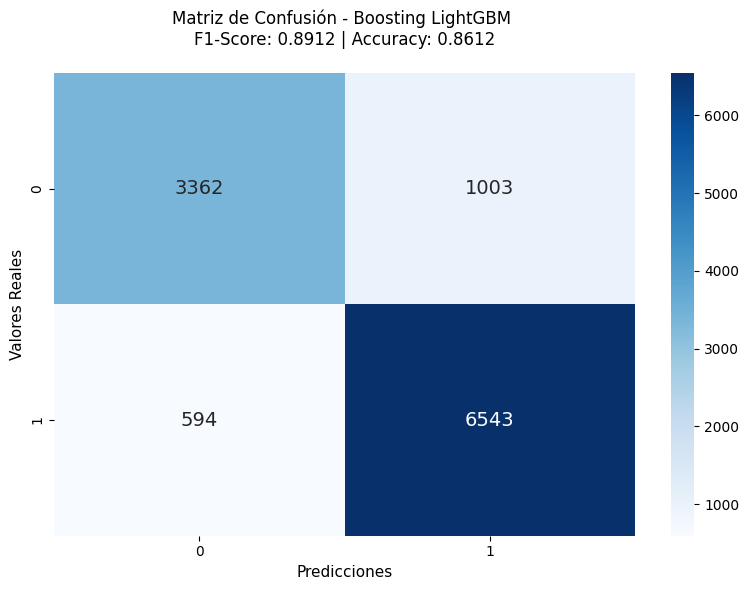

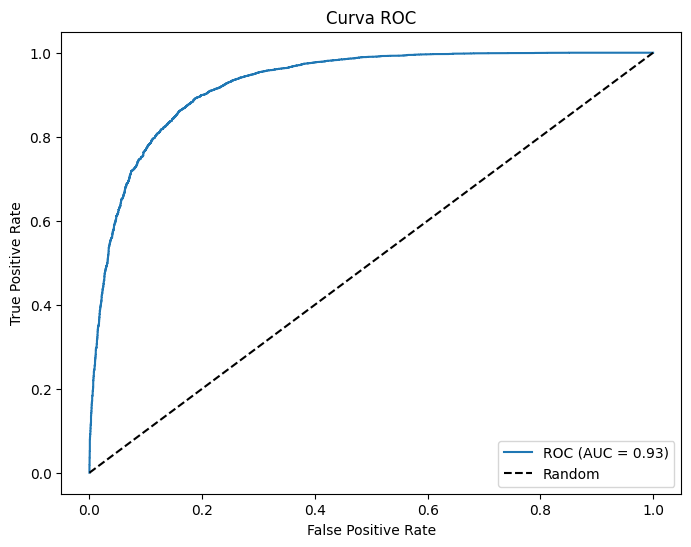

In [26]:
results = analyzer.evaluar_y_guardar_modelo(grid_search, X_test, y_test, y_pred, y_pred_proba,
                          nombre_modelo="Boosting LightGBM ")

In [27]:
results_df = pd.concat([results_df, results], ignore_index=True)
results_df.to_csv('../results/resultados_modelos_binaria.csv', index=False)

Pipeline detectado. Usando: LGBMClassifier


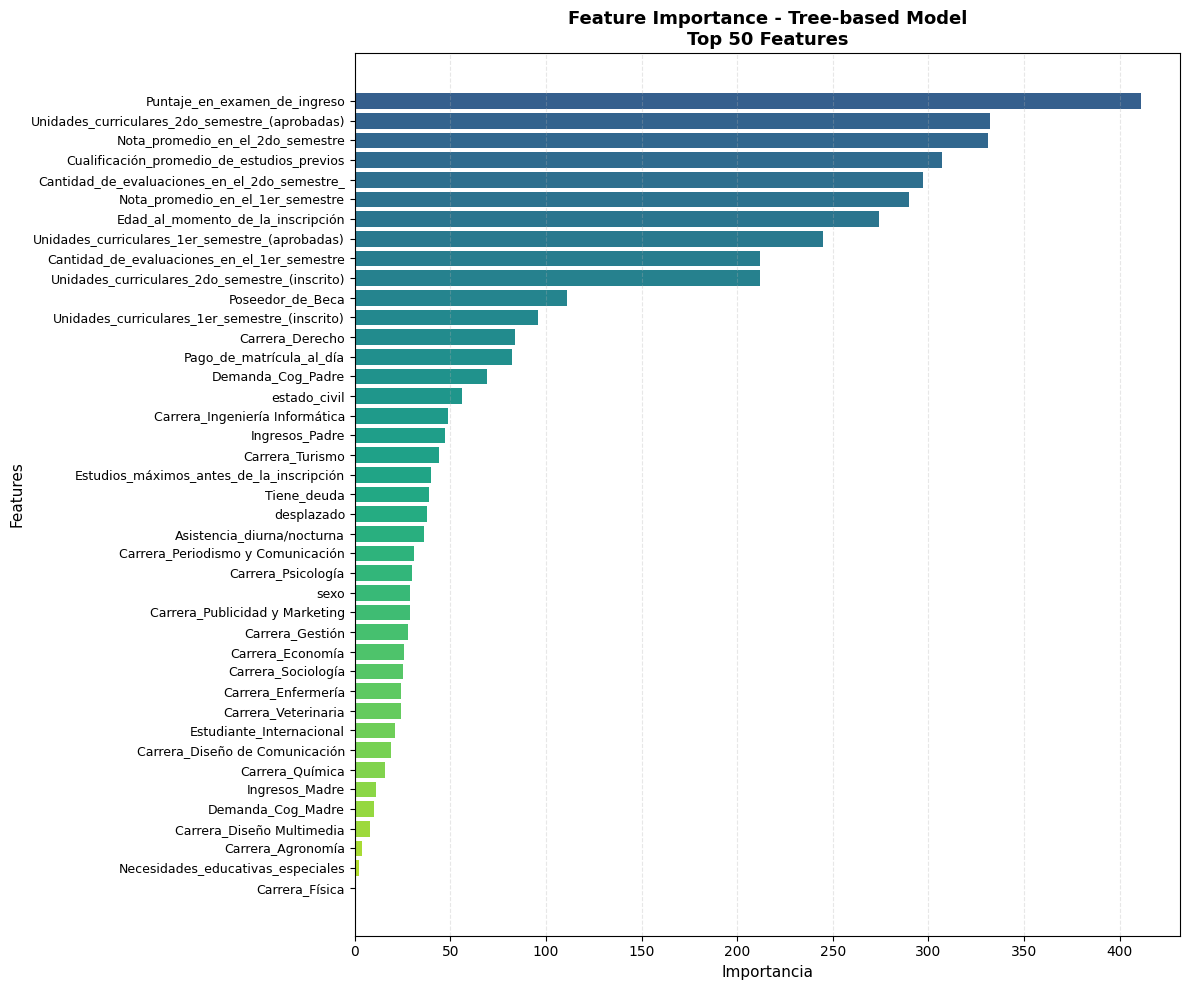


Top 41 Features:
                                       feature  importance
                  Puntaje_en_examen_de_ingreso         411
Unidades_curriculares_2do_semestre_(aprobadas)         332
              Nota_promedio_en_el_2do_semestre         331
    Cualificación_promedio_de_estudios_previos         307
  Cantidad_de_evaluaciones_en_el_2do_semestre_         297
              Nota_promedio_en_el_1er_semestre         290
             Edad_al_momento_de_la_inscripción         274
Unidades_curriculares_1er_semestre_(aprobadas)         245
   Cantidad_de_evaluaciones_en_el_1er_semestre         212
 Unidades_curriculares_2do_semestre_(inscrito)         212
                              Poseedor_de_Beca         111
 Unidades_curriculares_1er_semestre_(inscrito)          96
                               Carrera_Derecho          84
                      Pago_de_matrícula_al_día          82
                             Demanda_Cog_Padre          69
                                  esta

In [28]:
feature_importance_df = analyzer.plot_feature_importance(
    modelo=best_model,
    X_train=X_train,
    top_n=50,
    figsize=(12, 10))

## Optuna para RF

In [29]:
def objective(trial):
    # Definimos el espacio de búsqueda de hiperparámetros
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 2, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    
    # Definir el modelo
    modelo = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )
    
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    
    # Calcular accuracy
    acc = accuracy_score(y_test, y_pred)
    return acc

# Crear el estudio
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Mostrar los mejores parámetros y el mejor score
print("Mejores hiperparámetros:", study.best_params)
print("Mejor accuracy:", study.best_value)

[I 2025-10-17 18:25:33,902] A new study created in memory with name: no-name-42949992-3d6f-4709-ae78-055af7834b38
[I 2025-10-17 18:25:35,000] Trial 0 finished with value: 0.8388975830290384 and parameters: {'n_estimators': 275, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 0 with value: 0.8388975830290384.
[I 2025-10-17 18:25:35,962] Trial 1 finished with value: 0.8497652582159625 and parameters: {'n_estimators': 254, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 1 with value: 0.8497652582159625.
[I 2025-10-17 18:25:36,859] Trial 2 finished with value: 0.8433315945053034 and parameters: {'n_estimators': 239, 'max_depth': 5, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8497652582159625.
[I 2025-10-17 18:25:44,252] Trial 3 finished with value: 0.8544600938967136 and parameters: {'n_estimators': 290, 'max_depth': 19, 'mi

Mejores hiperparámetros: {'n_estimators': 225, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2'}
Mejor accuracy: 0.8613284646148496


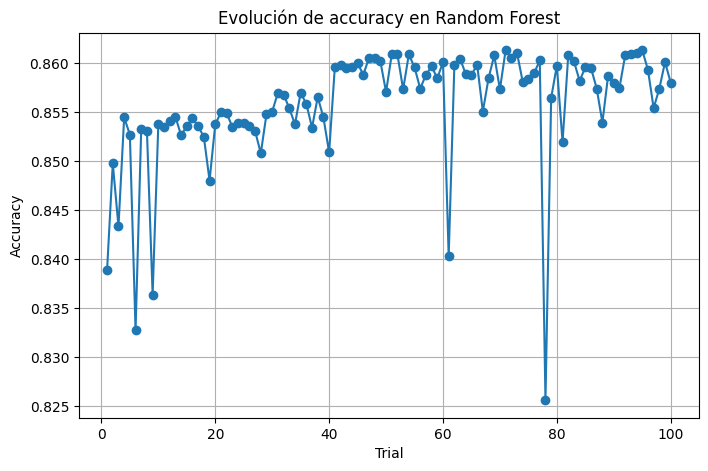

In [30]:
# Extraer los valores de accuracy de cada trial
accuracies = [t.value for t in study.trials]

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(accuracies)+1), accuracies, marker='o')
plt.title("Evolución de accuracy en Random Forest")
plt.xlabel("Trial")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

## VOTING

In [31]:
# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [32]:
pipe_lr = Pipeline([('lr', LogisticRegression(random_state=42, class_weight=None, max_iter=10000, C= 1, penalty= 'l2', solver= 'saga'))])

pipe_svm = Pipeline([('svm', SVC(probability=True, random_state=42, kernel='linear', C=1, gamma= 'scale'))])

pipe_knn = Pipeline([('knn', KNeighborsClassifier(n_neighbors= 20, weights= 'uniform', metric= 'manhattan'))])

pipe_rf = Pipeline([('rf', RandomForestClassifier(random_state=42, n_estimators=100, class_weight=None,  max_depth= 20, min_samples_split= 5))])

pipe_lgbm = Pipeline([('lgbm', lgb.LGBMClassifier(random_state=42, objective='binary', verbose=-1, n_jobs=-1, colsample_bytree= np.float64(0.8428136990746738), learning_rate= np.float64(0.06519983640450867), max_depth= 3, min_child_samples= 98, n_estimators= 620, num_leaves= 107, reg_alpha= np.float64(0.3948815181755697), reg_lambda= np.float64(0.2934881747180381), subsample= np.float64(0.6056319290860338)))])


voting_clf = VotingClassifier(
    estimators=[
        #('lr', pipe_lr),            
        ('svm', pipe_svm),
        ('knn', pipe_knn),
        ('rf', pipe_rf),
        ('lgbm', pipe_lgbm)], voting='hard')   


#voting concatena la información de todas las salidas para predecir.
voting_clf.fit(X_train_scaled, y_train)

,estimators,"[('svm', ...), ('knn', ...), ...]"
,voting,'hard'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,C,1
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0


VOTING CLASSIFIER - RESULTADO FINAL
              precision    recall  f1-score   support

           0       0.84      0.78      0.81      4365
           1       0.87      0.91      0.89      7137

    accuracy                           0.86     11502
   macro avg       0.86      0.85      0.85     11502
weighted avg       0.86      0.86      0.86     11502



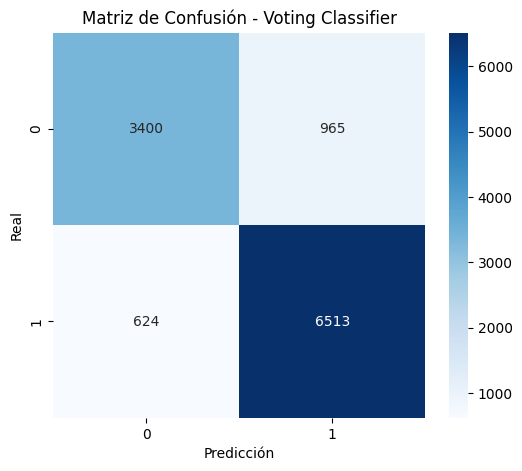

In [33]:
# Predicciones del voting classifier
y_pred_voting = voting_clf.predict(X_test_scaled)

print("VOTING CLASSIFIER - RESULTADO FINAL")
print("="*60)
print(classification_report(y_test, y_pred_voting))

# Matriz de confusión
cm_voting = confusion_matrix(y_test, y_pred_voting)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_voting, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Voting Classifier')
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.show()

In [34]:
accuracy = accuracy_score(y_test, y_pred_voting)
f1 = f1_score(y_test, y_pred_voting)
precision = precision_score(y_test, y_pred_voting)
recall = recall_score(y_test, y_pred_voting)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")


Accuracy:  0.8619
Precision: 0.8710
Recall:    0.9126
F1-Score:  0.8913
